True


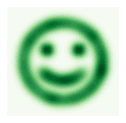

Epoch 1/10
19/19 [==============================] - 0s 2ms/step - loss: 0.7831 - acc: 0.6467
Epoch 2/10
19/19 [==============================] - 0s 2ms/step - loss: 0.5170 - acc: 0.7667
Epoch 3/10
19/19 [==============================] - 0s 2ms/step - loss: 0.3076 - acc: 0.9017
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0906 - acc: 0.9867
Epoch 5/10
19/19 [==============================] - 0s 2ms/step - loss: 0.0150 - acc: 1.0000
Epoch 6/10
19/19 [==============================] - 0s 2ms/step - loss: 0.0014 - acc: 1.0000
Epoch 7/10
19/19 [==============================] - 0s 2ms/step - loss: 1.4679e-04 - acc: 1.0000
Epoch 8/10
19/19 [==============================] - 0s 2ms/step - loss: 5.4564e-05 - acc: 1.0000
Epoch 9/10
19/19 [==============================] - 0s 2ms/step - loss: 2.8445e-05 - acc: 1.0000
Epoch 10/10
19/19 [==============================] - 0s 2ms/step - loss: 1.6593e-05 - acc: 1.0000


In [ ]:
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
print(tf.test.is_gpu_available())
from scipy.stats import wasserstein_distance

covs=[]   
means=[]
y=[]
#3std: number of high quality samples
#1std: number of modes captured
def one_point_in_mean(point, captured_number):
        for i,(mode_point,cov) in enumerate(zip(mean,covs)):
            if point[0] > mode_point[0]-3*cov[0] and point[0] < mode_point[0]+3*cov[0] and \
               point[1] > mode_point[1]-3*cov[1] and point[1] < mode_point[1]+3*cov[1]:
                if point[0] > mode_point[0]-1*cov[0] and point[0] < mode_point[0]+1*cov[0] and \
                   point[1] > mode_point[1]-1*cov[1] and point[1] < mode_point[1]+1*cov[1]:
                    captured_number.add(i)
                return True
        return False
def compute_high_qulity(points, captured_number):
    if points.shape[0] == 0:
      return 0
    number = 0
    for point in points:
        if one_point_in_mean(point, captured_number):
            number+=1
    return number/points.shape[0]
def high_qulity_and_number_of_captured(data, iters=1):
    high_qulity_score = 0.0
    captured_numbers = 0.0
    for i in range(iters):
        captured_number = set()
        high_qulity_score += compute_high_qulity(data,captured_number)
        captured_numbers += len(captured_number)
    return high_qulity_score/iters, captured_numbers/iters
#compute KL distance 
kl = tf.keras.losses.KLDivergence()
def compute_KL_distance(real_samples, generated_samples):
    return kl(tf.reduce_mean(classifier(real_samples),axis=0),tf.reduce_mean(classifier(generated_samples),axis=0))
def compute_W_distance(real_samples, generated_samples):
    return wasserstein_distance(tf.reduce_mean(classifier(real_samples),axis=0),tf.reduce_mean(classifier(generated_samples),axis=0))
#test function compute three metrics
def test_diversity_of_GAN(generator, iters=1, is_VEEGAN=False):
    """
    input
    iters: times of trial
    is_VEEGAN: is VEEGAN
    
    return 
    1.number of modes captured
    2.number of high quality samples
    3.KL distance
    """
    number_high_quality = 0.0
    number_modes = 0.0
    KL_distance = 0.0
    w_distance = 0.0
    for i in range(iters):
        if is_VEEGAN:
          sample_z = tf.random.normal((batch_size,z_dim))
        else:
          sample_z = tf.random.uniform((batch_size,z_dim), minval=-1, maxval=1)
        test_data = generator(sample_z)
        #select 2 or 3
        classified_result = np.argmax(classifier.predict(test_data),axis=1)
        condition = np.logical_or(classified_result==2, classified_result==3)
        compute_high_qulity_data = test_data[condition]
        temp_high_quality, temp_number_modes=high_qulity_and_number_of_captured(compute_high_qulity_data)
        number_high_quality += temp_high_quality
        number_modes += temp_number_modes
        KL_distance += compute_KL_distance(data, test_data.numpy())
        w_distance += compute_W_distance(data, test_data.numpy())
    return number_modes/iters,number_high_quality/iters,(KL_distance/iters).numpy(), w_distance/iters


def gen_clusters(mean, cov=0.001, number=50):
    cov_matrix = [[cov,0],[0,cov]]
    for i,m in enumerate(mean):
      y_train.extend([i+2]*number)
      if i == 0:
        data = np.random.multivariate_normal(m, cov_matrix, number)
        covs.append(np.std(data,axis=0).tolist())
        means.append(np.mean(data,axis=0).tolist())
      else:
        d = np.random.multivariate_normal(m,cov_matrix,number)
        covs.append(np.std(d,axis=0).tolist())
        means.append(np.mean(d,axis=0).tolist())
        data = np.append(data, d,0)  
    return np.round(data,4)
  
def save_data(data,filename):
    with open(filename,'w') as file:
        for i in range(data.shape[0]):
            file.write(str(data[i,0])+','+str(data[i,1])+'\n')
            
def load_data(filename):
    data = []
    with open(filename,'r') as file:
        for line in file.readlines():
            data.append([ float(i) for i in line.split(',')])
    return np.array(data)

def show_scatter(data):
    x,y = data.T
    plt.figure(figsize=(2,2))
    flatui = ["#2ecc71"]
    plt.scatter(x,y,c="g",alpha=0.1)
    
    # sns.scatterplot(x,y,palette=sns.color_palette(flatui),alpha=0.5)
    plt.axis()
    plt.title("scatter")
    plt.xticks([-1,0,1])
    plt.yticks([-1,0,1])
    plt.show()
    
def show_scatter(data, color="Greens", epsilon=1e-9):
    
    data+=epsilon
    plt.figure(figsize=(2,2))
    bg_color=sns.color_palette(color, n_colors=256)[0]
    ax=sns.kdeplot(data[:,0],data[:,1], shade=True, cmap=color, n_levels=30)
    # plt.xticks([-1,0,1])
    # plt.yticks([-1,0,1])
    plt.axis('off')
    plt.show()



# offset = 0.7
# mean = [[0,-1],[0,1],[-1,0],[1,0],[-offset,offset],[-offset,-offset],[offset,offset],[offset,-offset]]

from sklearn import datasets
%matplotlib inline

y_train = []
#outer cicle
n_samples = 2200
np.random.seed(0)
t = 2 * np.pi * (np.random.uniform(size=(1,n_samples)))
x = np.cos(t)
y = np.sin(t)
data = np.concatenate([x,y],axis=0).T
x_train = np.array(data[:150])
y_train.extend([0]*150)
#mouth
t = 5.8-np.pi * (np.random.uniform(0,0.7,size=(1,500)))
x = 0.6*np.cos(t)
y = 0.5*np.sin(t)
mouth_data = np.concatenate([x,y],axis=0).T
data = np.concatenate((data,mouth_data))
x_train = np.concatenate((x_train,mouth_data[:150]))
y_train.extend([1]*150)
#eyes
mean = [[-0.4,0.3],[0.4,0.3]]
eyes_data = gen_clusters(mean,cov=1e-4,number=150)
data = np.concatenate((data,eyes_data))
x_train = np.concatenate((x_train,eyes_data))


show_scatter(data)



epochs = 200000
classifier = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dense(len(mean)+2,activation="softmax"),
])
classifier.compile(optimizer="adam",loss=tf.losses.sparse_categorical_crossentropy,metrics=["acc"])
classifier.fit(x_train,np.array(y_train),epochs=10)

# CKGAN using linear combination of characteristic kernels

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              3072      
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 1024)             

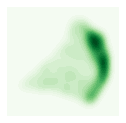

epoch: 1000 generator_loss: -1.470541 discriminator_loss: -0.002639789
(1.0, 0.10465116279069768, 0.00665842, 0.023184942081570625)


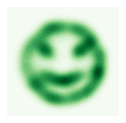

KeyboardInterrupt: 

In [ ]:
batch_size=data.shape[0]
z_dim = 2
units = 1024
# ========================== generator ===========================
z_in = tf.keras.layers.Input(shape=(z_dim, ))
inputs = tf.keras.layers.Dense(units)(z_in)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.ReLU()(inputs)

inputs = tf.keras.layers.Dense(units)(inputs)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.ReLU()(inputs)

inputs = tf.keras.layers.Dense(units)(inputs)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.ReLU()(inputs)



inputs = tf.keras.layers.Dense(z_dim)(inputs)
generator = tf.keras.Model(z_in, inputs)
generator.summary()
sample_z = tf.random.uniform((batch_size,z_dim),minval=-1,maxval=1)
generator(sample_z).shape


# ========================== discriminator ===========================
x_in = tf.keras.layers.Input(shape=(z_dim, )) #
inputs = tf.keras.layers.Dense(units)(x_in)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.ReLU()(inputs)

inputs = tf.keras.layers.Dense(units)(inputs)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.ReLU()(inputs)



inputs = tf.keras.layers.Dense(z_dim)(inputs) 
discriminator = tf.keras.Model(x_in, inputs)
discriminator.summary()
discriminator(data).shape



class LearnedKernel(tf.keras.Model):

  def __init__(self, is_use_softmax = False, is_use_one_hot = False):
    super(LearnedKernel,self).__init__()
    self.is_use_softmax = is_use_softmax
    self.is_use_one_hot = is_use_one_hot
    self.kernel_function = [self.gaussian_kernel, self.rbf_kernel, self.laplacian_kernel, 
                 self.exponential_kernel, self.martern_3_2_kernel, self.martern_5_2_kernel]
    self.variable_one = tf.ones((len(self.kernel_function,)))

  def build(self, input_shape):
    self.kernel_weight = self.add_weight("kernel_weight", shape=[len(self.kernel_function)])

  def call(self, x, y):
    kernel_weight = self.kernel_weight
    if self.is_use_softmax:
      kernel_weight = tf.nn.softmax(tf.multiply(self.kernel_weight, self.variable_one))

      if self.is_use_one_hot:
        # generae one_hot vector
        masked_one_hot = tf.one_hot(tf.argmax(kernel_weight), len(self.kernel_function))
        kernel_weight = tf.multiply(kernel_weight, masked_one_hot)

    # print("kernel_weight", kernel_weight)
    output = 0
    for i in range(len(self.kernel_function)):
      output += kernel_weight[i] * self.kernel_function[i](x,y)
    return output

  def gaussian_kernel(self, a,b, sigma=10):
    return tf.exp(-tf.divide(tf.norm(a-b,axis=-1)**2, 2*sigma**2))
  def rbf_kernel(self, a,b, K=5):
    k = 0
    sigma_q = 0.5
    for k in range(K):
      k += self.gaussian_kernel(a,b,sigma_q)
      sigma_q *= 2
    return k
  def laplacian_kernel(self, a,b, sigma=100):
    return tf.exp(-tf.divide(tf.norm(a-b, ord=1, axis=-1), sigma))
  def exponential_kernel(self, a,b,sigma=10):
    return tf.exp(-tf.divide(tf.norm(a-b, axis=-1), sigma))
  def martern_3_2_kernel(self, a,b,alpha=1,l=10):
    sqrt_3 = tf.sqrt(3.)
    def r_function(a,b):
      return tf.norm(a-b, axis=-1)/l
    r = r_function(a,b)
    return alpha*(1+sqrt_3*r)*tf.exp(-sqrt_3*r)
  def martern_5_2_kernel(self, a,b,alpha=1,l=10):
    sqrt_5 = tf.sqrt(5.)
    def r_function(a,b):
      return tf.norm(a-b, axis=-1)/l
    r = r_function(a,b)
    return alpha*(1+sqrt_5*r+(5./3.)*r**2)*tf.exp(-sqrt_5*r)

learned_kernel = LearnedKernel(is_use_softmax = True, is_use_one_hot = False)




loss_obj = tf.nn.sigmoid_cross_entropy_with_logits
lr = 1e-4
generator_optimizer = tf.optimizers.RMSprop(lr,0.99)
discriminator_optimizer = tf.optimizers.RMSprop(lr,0.99)


def loss_ones_fn(logits):
  y = tf.ones_like(logits)
  loss = loss_obj(y,logits)
  return tf.reduce_mean(loss)
def loss_zeros_fn(logits):
  y = tf.zeros_like(logits)
  loss = loss_obj(y,logits)
  return tf.reduce_mean(loss)
def correlation(x, y):
    x = tf.reshape(x,shape=(x.shape[0], -1))
    y = tf.reshape(y,shape=(y.shape[0], -1))
    x = x - tf.reduce_mean(x, 1, keepdims=True)
    y = y - tf.reduce_mean(y, 1, keepdims=True)
    x = tf.nn.l2_normalize(x, 1)
    y = tf.nn.l2_normalize(y, 1)
    return tf.reduce_sum(x * y, 1)
def cosine_similarity_loss(a,b):
  return tf.divide(tf.reduce_sum(tf.multiply(a,b),axis=1),tf.norm(a,axis=1)*tf.norm(b,axis=1))

def gaussian_kernel(a,b, sigma=10):
  return tf.exp(-tf.divide(tf.norm(a-b,axis=-1)**2, 2*sigma**2))
def rbf_kernel(a,b, K=5):
  k = 0
  sigma_q = 0.5
  for k in range(K):
    k += gaussian_kernel(a,b,sigma_q)
    sigma_q *= 2
  return k
def laplacian_kernel(a,b, sigma=100):
  return tf.exp(-tf.divide(tf.norm(a-b, ord=1, axis=-1), sigma))
def exponential_kernel(a,b,sigma=10):
  return tf.exp(-tf.divide(tf.norm(a-b, axis=-1), sigma))
def martern_3_2_kernel(a,b,alpha=1,l=10):
  sqrt_3 = tf.sqrt(3.)
  def r_function(a,b):
    return tf.norm(a-b, axis=-1)/l
  r = r_function(a,b)
  return alpha*(1+sqrt_3*r)*tf.exp(-sqrt_3*r)
def martern_5_2_kernel(a,b,alpha=1,l=10):
  sqrt_5 = tf.sqrt(5.)
  def r_function(a,b):
    return tf.norm(a-b, axis=-1)/l
  r = r_function(a,b)
  return alpha*(1+sqrt_5*r+(5./3.)*r**2)*tf.exp(-sqrt_5*r)

def gradient_penalty(real_data, generated_data):
    alpha = tf.random.uniform((batch_size,1,),minval=0,maxval=1,dtype=tf.float32)

    interpolated = alpha * real_data + (1 - alpha) * generated_data
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        prob_interpolated = discriminator(interpolated)
    gradients = tape.gradient(prob_interpolated,interpolated)
    gradients = tf.reshape(gradients,(batch_size,-1))
    gradients_norm = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=1))
    # Return gradient penalty
    return 0.01*tf.reduce_mean((gradients_norm - 1) ** 2)



@tf.function
def train(real_images,k=learned_kernel, _lambda=0.5):
    
    # Note that we don't use gradient panelty on sythetic datasets.
    # train discrimnator
#     for i in range(5):
    with tf.GradientTape() as discriminator_tape:
        z = tf.random.uniform((batch_size, z_dim),minval=-1.0, maxval=1.0)
        x = generator(z)  
        x_fake = discriminator(x)
        discriminator_loss = -k(z,discriminator(real_images)) + k(x_fake,z)  #+ gradient_penalty(real_images,x)
        discriminator_loss = tf.reduce_mean(discriminator_loss)  
    discriminator_grads = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables+learned_kernel.trainable_variables )
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables+learned_kernel.trainable_variables ))

    # train generator
    with tf.GradientTape() as generator_tape:
        z  = tf.random.uniform((batch_size, z_dim),minval=-1.0,maxval=1.0)
        x_fake = discriminator(generator(z))
        generator_loss = tf.reduce_mean(-k(x_fake,z))
    generator_grads = generator_tape.gradient(generator_loss, generator.trainable_variables+learned_kernel.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables+learned_kernel.trainable_variables))
    return generator_loss,discriminator_loss

data = tf.cast(data,tf.float32)
train(data)


epochs = epochs

for epoch in range(epochs):
    generator_loss,discriminator_loss = train(data)
    if epoch%1000 == 0:
        print("epoch:",epoch,
              "generator_loss:",generator_loss.numpy(), 
              "discriminator_loss:",discriminator_loss.numpy())  
        sample_z = tf.random.uniform((batch_size,z_dim), minval=-1, maxval=1)
        sample_fake_image = generator(sample_z)
        print(test_diversity_of_GAN(generator,1))
        show_scatter(sample_fake_image.numpy())

# CKGAN using single characteristic kernel

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              3072      
_________________________________________________________________
batch_normalization_10 (Batc (None, 1024)              4096      
_________________________________________________________________
re_lu_10 (ReLU)              (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_11 (Batc (None, 1024)              4096      
_________________________________________________________________
re_lu_11 (ReLU)              (None, 1024)             

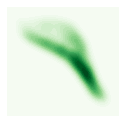

epoch: 1000 generator_loss: -0.68572056 discriminator_loss: -0.0022263532
(0.0, 0.013289036544850499, 0.0036791826, 0.017362697049975395)


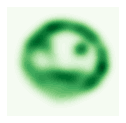

epoch: 2000 generator_loss: -0.58871824 discriminator_loss: -0.003252937
(2.0, 0.5391566265060241, 0.0006353175, 0.005701315589249134)


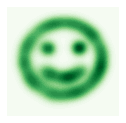

KeyboardInterrupt: 

In [ ]:
batch_size=data.shape[0]
z_dim = 2
units = 1024
# ========================== generator ===========================
z_in = tf.keras.layers.Input(shape=(z_dim, ))
inputs = tf.keras.layers.Dense(units)(z_in)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.ReLU()(inputs)

inputs = tf.keras.layers.Dense(units)(inputs)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.ReLU()(inputs)

inputs = tf.keras.layers.Dense(units)(inputs)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.ReLU()(inputs)

inputs = tf.keras.layers.Dense(z_dim)(inputs)
generator = tf.keras.Model(z_in, inputs)
generator.summary()
sample_z = tf.random.uniform((batch_size,z_dim),minval=-1,maxval=1)
generator(sample_z).shape


# ========================== discriminator ===========================
x_in = tf.keras.layers.Input(shape=(z_dim, )) #
inputs = tf.keras.layers.Dense(units)(x_in)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.ReLU()(inputs)

inputs = tf.keras.layers.Dense(units)(inputs)
inputs = tf.keras.layers.BatchNormalization()(inputs)
inputs = tf.keras.layers.ReLU()(inputs)


inputs = tf.keras.layers.Dense(z_dim)(inputs) 
discriminator = tf.keras.Model(x_in, inputs)
discriminator.summary()
discriminator(data).shape



loss_obj = tf.nn.sigmoid_cross_entropy_with_logits
lr = 1e-4
generator_optimizer = tf.optimizers.RMSprop(lr,0.99)
discriminator_optimizer = tf.optimizers.RMSprop(lr,0.99)


def loss_ones_fn(logits):
  y = tf.ones_like(logits)
  loss = loss_obj(y,logits)
  return tf.reduce_mean(loss)
def loss_zeros_fn(logits):
  y = tf.zeros_like(logits)
  loss = loss_obj(y,logits)
  return tf.reduce_mean(loss)
def correlation(x, y):
    x = tf.reshape(x,shape=(x.shape[0], -1))
    y = tf.reshape(y,shape=(y.shape[0], -1))
    x = x - tf.reduce_mean(x, 1, keepdims=True)
    y = y - tf.reduce_mean(y, 1, keepdims=True)
    x = tf.nn.l2_normalize(x, 1)
    y = tf.nn.l2_normalize(y, 1)
    return tf.reduce_sum(x * y, 1)
def cosine_similarity_loss(a,b):
  return tf.divide(tf.reduce_sum(tf.multiply(a,b),axis=1),tf.norm(a,axis=1)*tf.norm(b,axis=1))

def gaussian_kernel(a,b, sigma=10):
  return tf.exp(-tf.divide(tf.norm(a-b,axis=-1)**2, 2*sigma**2))
def rbf_kernel(a,b, K=5):
  k = 0
  sigma_q = 0.5
  for k in range(K):
    k += gaussian_kernel(a,b,sigma_q)
    sigma_q *= 2
  return k
def laplacian_kernel(a,b, sigma=100):
  return tf.exp(-tf.divide(tf.norm(a-b, ord=1, axis=-1), sigma))
def exponential_kernel(a,b,sigma=10):
  return tf.exp(-tf.divide(tf.norm(a-b, axis=-1), sigma))
def martern_3_2_kernel(a,b,alpha=1,l=10):
  sqrt_3 = tf.sqrt(3.)
  def r_function(a,b):
    return tf.norm(a-b, axis=-1)/l
  r = r_function(a,b)
  return alpha*(1+sqrt_3*r)*tf.exp(-sqrt_3*r)
def martern_5_2_kernel(a,b,alpha=1,l=10):
  sqrt_5 = tf.sqrt(5.)
  def r_function(a,b):
    return tf.norm(a-b, axis=-1)/l
  r = r_function(a,b)
  return alpha*(1+sqrt_5*r+(5./3.)*r**2)*tf.exp(-sqrt_5*r)


def gradient_penalty(real_data, generated_data):
    alpha = tf.random.uniform((batch_size,1,),minval=0,maxval=1,dtype=tf.float32)

    interpolated = alpha * real_data + (1 - alpha) * generated_data
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        prob_interpolated = discriminator(interpolated)
        gradients = tape.gradient(prob_interpolated,interpolated)

    gradients = tf.reshape(gradients,(batch_size,-1))
    gradients_norm = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=1))
    # Return gradient penalty
    return 0.01*tf.reduce_mean((gradients_norm - 1) ** 2)



@tf.function
def train(real_images,k=gaussian_kernel, _lambda=0.5):
    
    # Note that we don't use gradient panelty on sythetic datasets.
    # train discrimnator
#     for i in range(5):
    with tf.GradientTape() as discriminator_tape:
        z = tf.random.uniform((batch_size, z_dim),minval=-1.0, maxval=1.0)
        x = generator(z)  
        x_fake = discriminator(x)
        discriminator_loss = -k(z,discriminator(real_images)) + k(x_fake,z)  #+ gradient_penalty(real_images,x)
        discriminator_loss = tf.reduce_mean(discriminator_loss)  
    discriminator_grads = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables )
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables ))

    # train generator
    with tf.GradientTape() as generator_tape:
        z  = tf.random.uniform((batch_size, z_dim),minval=-1.0,maxval=1.0)
        x_fake = discriminator(generator(z))
        generator_loss = tf.reduce_mean(-k(x_fake,z))
    generator_grads = generator_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    return generator_loss,discriminator_loss

data = tf.cast(data,tf.float32)
train(data)


epochs = epochs

for epoch in range(epochs):
    generator_loss,discriminator_loss = train(data)
    if epoch%1000 == 0:
        print("epoch:",epoch,
              "generator_loss:",generator_loss.numpy(), 
              "discriminator_loss:",discriminator_loss.numpy())  
        sample_z = tf.random.uniform((batch_size,z_dim), minval=-1, maxval=1)
        sample_fake_image = generator(sample_z)
        print(test_diversity_of_GAN(generator,1))
        show_scatter(sample_fake_image.numpy())
